In [1]:
import ctypes
from ctypes import c_char_p
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert('L')  # Conversion en gris
        img = Image.open(img_path).convert('RGB')  # Conversion en gris
        img = img.resize((32, 32))  # Resize les images
        img_array = np.array(img, dtype=np.float64).flatten()  # Flatten les vecteurs
        images.append(img_array)
        labels.append(label)
    return images, labels

folder_a = 'data/dataset/resized/gas_giant'
folder_b = 'data/dataset/resized/neptune-like'
folder_c = 'data/dataset/resized/super_earth'

images_a, labels_a = load_images_from_folder(folder_a, [1.0, 0.0, 0.0])
images_b, labels_b = load_images_from_folder(folder_b, [0.0, 1.0, 0.0])
images_c, labels_c = load_images_from_folder(folder_c, [0.0, 0.0, 1.0])

X = np.array(images_a + images_b + images_c)
y = np.array(labels_a + labels_b + labels_c)

# Séparer les données entrainement / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Training data shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test data shape: {y_test.shape}")

Training data shape: (1200, 3072)
Training data shape: (1200, 3)
Test data shape: (300, 3072)
Test data shape: (300, 3)


In [3]:
def display_selected_images(images, labels, indices, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(indices):
            index = indices[i]
            # image_2d = images[index].reshape((64, 64)) 
            image_3d = images[index].reshape((32, 32, 3)) 
            if image_3d.max() > 1.0:
                image_3d = image_3d / 255.0 
            # ax.imshow(image_2d, cmap='gray')
            ax.imshow(image_3d)
            ax.set_title(f"Label: {labels[index]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

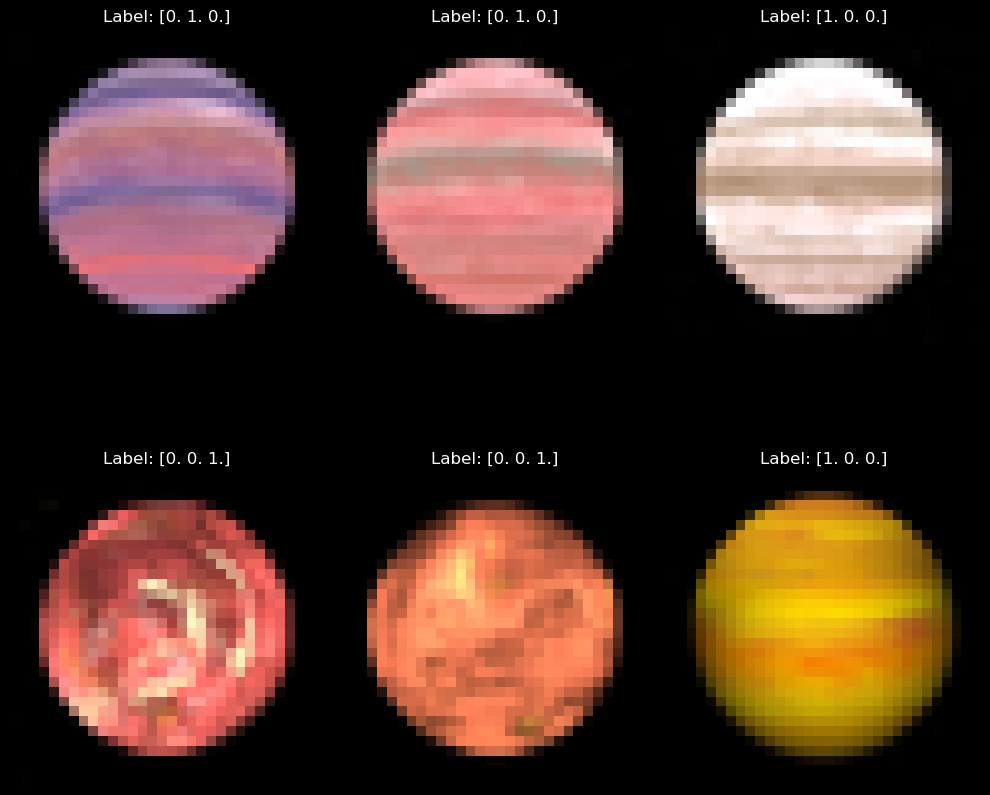

In [4]:
selected_indices = [39, 100, 70, 320, 230, 159]
nrows, ncols = 2, 3

display_selected_images(X_train, y_train, selected_indices, nrows, ncols)

# Perceptron multi couche

In [5]:
mlp_model = ctypes.CDLL("modele/mlp/target/release/libmlp_classification.so")

# Définir les types d'arguments et de retour des fonctions C
PROGRESS_CALLBACK = ctypes.CFUNCTYPE(None, ctypes.c_int, ctypes.c_double)
mlp_model.mlpInit.argtypes = [ctypes.POINTER(ctypes.c_uint), ctypes.c_size_t, ctypes.c_double]
mlp_model.mlpInit.restype = ctypes.POINTER(ctypes.c_void_p)

mlp_model.mlpTrain.argtypes = [
    ctypes.POINTER(ctypes.c_void_p),
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_bool,
    PROGRESS_CALLBACK,
    ctypes.c_size_t
]
mlp_model.mlpTrain.restype = ctypes.c_double


mlp_model.mlpPredict.argtypes = [
    ctypes.POINTER(ctypes.c_void_p),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.POINTER(ctypes.c_double)
]
mlp_model.mlpPredict.restype = None

mlp_model.mlpFree.argtypes = [ctypes.POINTER(ctypes.c_void_p)]
mlp_model.mlpFree.restype = None

In [6]:
print(f"vecteur : {X_train}")
print(f"type : {type(X_train[0][0])}")
print(f"pointer : {X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double))}")
print(f"Training data shape: {X_train.shape}")
print(f"Training data shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test data shape: {y_test.shape}")

vecteur : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
type : <class 'numpy.float64'>
pointer : <__main__.LP_c_double object at 0x7fae6893dad0>
Training data shape: (1200, 3072)
Training data shape: (1200, 3)
Test data shape: (300, 3072)
Test data shape: (300, 3)


In [13]:
neurons_size = np.array([X_train.shape[1], 32, 16, 8, 3], dtype=np.uintp)
learning_rate = 0.001
epochs = 1000
callback_interval = 10

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_uint))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

layer : 4
neural matrix : [NeuralMatrix { matrix: [[0.15390016339156132, -0.9670224002340757, 0.7584828228655165, 0.19725281194503497, -0.6712696268816822, 0.2860344015541645, -0.23039530105159844, -0.42093701523311466, -0.07431805532883518, -0.07958147065582821, -0.5564670078736014, 0.5887987798378767, -0.047187630840152206, 0.543896020671911, 0.9032782557291821, -0.2054176141413686, 0.9143879199845872, 0.11754999114853382, -0.5307851069353, -0.08708816943162923, 0.7128562791479953, 0.9895158161000204, -0.47179080442802857, -0.49920354388897037, -0.6249937005679809, -0.08052298826175219, 0.7959625098882395, -0.28415491616360633, 0.9739379139187299, -0.6859567364455028, -0.8281531076569246, -0.6022161191539719, -0.4826181454714127, 0.11848747883853727, 0.6022391845756574, -0.7072558050707096, 0.012259402139075615, 0.2521105637964576, 0.2532092239442534, -0.6087038557565658, -0.467640864836949, 0.07558239205358541, 0.5608320127308675, -0.9759027256633983, -0.13912201399566548, 0.2711882

In [14]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs,
    8,
    True,
    callback_func,
    callback_interval  
)
progress_bar.close()

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
predictions_list = []
labels_list = []

for k in range(len(X_test)):
    predictions = np.zeros(y_train.shape[1], dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_test[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_test[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    predictions_list.append(predictions)
    labels_list.append(y_test[k])

In [16]:
predictions_array = np.array(predictions_list)
labels_array = np.array(labels_list)

for i in range(10):
    print(f"Sample {i}, True Label: {labels_array[i]}, Predictions: {predictions_array[i]}")

accuracy = np.mean(np.argmax(predictions_array, axis=1) == np.argmax(labels_array, axis=1))
print(f"Accuracy: {accuracy * 100:.2f}%")

Sample 0, True Label: [0. 0. 1.], Predictions: [0.33014735 0.34254466 0.32730799]
Sample 1, True Label: [0. 0. 1.], Predictions: [0.32971129 0.34307498 0.32721374]
Sample 2, True Label: [1. 0. 0.], Predictions: [0.32971129 0.34307498 0.32721374]
Sample 3, True Label: [1. 0. 0.], Predictions: [0.32971129 0.34307498 0.32721374]
Sample 4, True Label: [1. 0. 0.], Predictions: [0.33014735 0.34254466 0.32730799]
Sample 5, True Label: [0. 1. 0.], Predictions: [0.32971129 0.34307498 0.32721374]
Sample 6, True Label: [0. 0. 1.], Predictions: [0.32971129 0.34307498 0.32721374]
Sample 7, True Label: [0. 1. 0.], Predictions: [0.32971129 0.34307498 0.32721374]
Sample 8, True Label: [0. 0. 1.], Predictions: [0.32971129 0.34307498 0.32721374]
Sample 9, True Label: [1. 0. 0.], Predictions: [0.32971129 0.34307498 0.32721374]
Accuracy: 28.67%


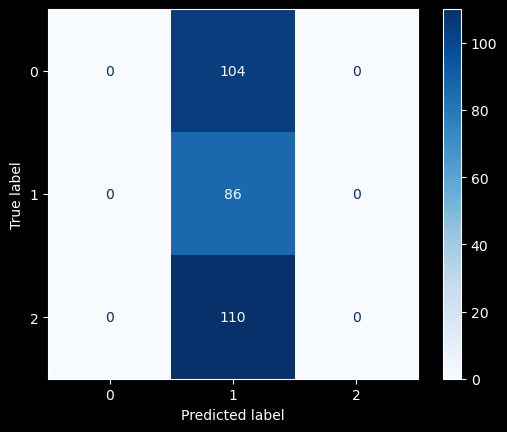

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(np.argmax(labels_array, axis=1), np.argmax(predictions_array, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [18]:
mlp_model.mlpFree(nn)